In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#from load_keypoints import bodypart_index

In [17]:
# loads from saved file
with open("pose_data.jsonl") as f:
    data = [json.loads(line) for line in f if line.strip()]

In [18]:
vid_index = 0
frame_index = 0
bodypart_index = 0
data[vid_index]['keypoints'][frame_index][bodypart_index][:2]

[623.677978515625, 336.6422119140625]

In [19]:
# normalizes by the difference of the first
#sdef get_positions(data, video_index):
#    keypoints = np.array(data[video_index]['keypoints'])[:, :, :2]
#    first_keypoints = keypoints[0]
#    return keypoints - first_keypoints

import numpy as np

def get_positions(data, video_index, center_by="first_frame", normalize_by = "-1 to 1"):
    """
    Extract and normalize (x, y) keypoints for a given video.

    Args:
        data: list/dict containing keypoints per video
        video_index: which video to extract
        center_by: which joint to center on ("pelvis", "first_frame", None)
        normalize_by: ("global", "local", None)
    Returns:
        np.ndarray of shape (frames, joints, 2)
    """
    keypoints = np.array(data[video_index]['keypoints'])[:, :, :2]  # (frames, joints, 2)

    if center_by == "pelvis":
        pelvis = (keypoints[:, 11] + keypoints[:, 12]) / 2  # left+right hip
        keypoints = keypoints - pelvis[:, None, :]

    elif center_by == "first_frame":
        keypoints = keypoints - keypoints[0]

    # finds the max/min in all frames
    if normalize_by == "-1 to 1":
        x_min = keypoints.min()
        x_max = keypoints.max()
        keypoints = 2 * (keypoints - x_min) / (x_max - x_min) - 1

    elif normalize_by == "0 to 1":
        x_min = keypoints.min()
        x_max = keypoints.max()
        keypoints = (keypoints - x_min) / (x_max - x_min)

    # finds the max/min per podypart in all frames
    elif normalize_by == "local":
        x_min = keypoints.min(axis=0, keepdims=True)
        x_max = keypoints.max(axis=0, keepdims=True)
        keypoints = 2 * (keypoints - x_min) / (x_max - x_min) - 1

    return keypoints

In [20]:
def get_velocitys(data, video_index):
    keypoints = data[video_index]['keypoints']
    keypoints = np.array(keypoints)
    keypoints = keypoints[:, :, :2]
    velocities = np.diff(keypoints, axis=0)
    return velocities

In [21]:
def get_position_velocity(data, video_index):
    positions = get_positions(data, video_index)
    velocities = get_velocitys(data, video_index)
    merged = np.concatenate([positions[:-1], velocities], axis=-1)
    return merged

In [22]:
for i in range(0, len(data)):
    keypoints = data[i]['keypoints']
    gesture_id = data[i]['gesture_id']

    if keypoints:
        X = get_position_velocity(data, i)
        Y = gesture_id

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
# -------------------------
# Dataset definition
# -------------------------
class PoseGestureDataset(Dataset):
    def __init__(self, data, get_position_velocity_fn):
        """
        Args:
            data: list of dicts, each like {'keypoints': ..., 'gesture_id': ...}
            get_position_velocity_fn: function(data, i) -> torch.Tensor or np.ndarray
        """
        self.samples = []
        for i in range(len(data)):
            keypoints = data[i].get('keypoints')
            gesture_id = data[i].get('gesture_id')

            if keypoints:
                X = get_position_velocity_fn(data, i)  # (Ni, 17, 4)
                Y = gesture_id
                if isinstance(X, np.ndarray):
                    X = torch.tensor(X, dtype=torch.float32)
                self.samples.append((X, Y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, Y = self.samples[idx]
        X = X.view(X.shape[0], -1)  # flatten to (Ni, 68)
        return X, torch.tensor(Y, dtype=torch.long)

    # shuffle the samples
    def shuffle(self, seed = 42):
        random.seed(seed)
        self.samples = random.sample(self.samples, len(self.samples))


In [24]:
# -------------------------
# Collate function for variable-length sequences
# -------------------------
def pad_collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = [seq.shape[0] for seq in sequences]

    padded_X = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    return padded_X, labels, torch.tensor(lengths, dtype=torch.long)



# -------------------------
# Example usage
# -------------------------
# Create dataset and dataloader
dataset = PoseGestureDataset(data, get_position_velocity)
dataset.shuffle(seed = 420)

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=pad_collate_fn
)

# Inspect one batch
for X, Y, lengths in loader:
    print("Batch X shape:", X.shape)   # (batch_size, max_seq_len, 68)
    print("Batch Y shape:", Y.shape)   # (batch_size,)
    print("Sequence lengths:", lengths)

    print(X)
    print(Y)
    break

Batch X shape: torch.Size([2, 36, 68])
Batch Y shape: torch.Size([2])
Sequence lengths: tensor([29, 36])
tensor([[[ 5.7569e-01,  5.7569e-01, -4.9840e+00,  ...,  5.7569e-01,
           3.7725e+01,  0.0000e+00],
         [ 5.3885e-01,  5.1616e-01,  4.3854e-01,  ...,  5.7569e-01,
           7.5714e-01,  0.0000e+00],
         [ 5.4209e-01,  5.1260e-01, -4.0594e-01,  ...,  5.7569e-01,
          -3.7213e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 3.8339e-01,  3.8339e-01,  1.6690e+00,  ...,  3.8339e-01,
          -1.1771e+01,  0.0000e+00],
         [ 3.9002e-01,  3.9985e-01, -1.4655e-01,  ...,  3.8339e-01,
          -2.8482e+00,  0.0000e+00],
         [ 3.8944e-01,  4.0636e-01,  1.

In [25]:
from torch.utils.data import DataLoader, random_split

# ----- Dataset -----
dataset = PoseGestureDataset(data, get_position_velocity)

# ----- Split -----
total_len = len(dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_len = int(total_len * train_ratio)
val_len = int(total_len * val_ratio)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# ----- DataLoaders with padding collate_fn -----
batch_size = 10

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn
)

# ----- Verify -----
for X, Y, lengths in train_loader:
    print("Train batch X shape:", X.shape)
    print("Train batch Y shape:", Y.shape)
    print("Sequence lengths:", lengths)
    break

Train batch X shape: torch.Size([10, 77, 68])
Train batch Y shape: torch.Size([10])
Sequence lengths: tensor([47, 51, 47, 52, 70, 44, 47, 26, 60, 77])


In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

# -------------------------
# Assume dataset, pad_collate_fn, train_loader, val_loader, test_loader are already defined
# -------------------------

# ----- Bi-LSTM Model -----
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=68, hidden_size=128, num_layers=2, num_classes=3):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed)
        out = torch.cat((hn[-2], hn[-1]), dim=1)  # concatenate both directions
        out = self.fc(out)
        return out

# ----- Setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set([data[i]['gesture_id'] for i in range(len(data)) if data[i]['keypoints']]))
model = BiLSTMClassifier(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----- Training Parameters -----
num_epochs = 30  # adjust as needed

# Store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ----- Training Loop -----
for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    for X, Y, lengths in train_loader:
        X, Y, lengths = X.to(device), Y.to(device), lengths.to(device)

        optimizer.zero_grad()
        outputs = model(X, lengths)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Y.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == Y).sum().item()
        total_samples += Y.size(0)

    train_acc = total_correct / total_samples
    train_loss = total_loss / total_samples

    # ----- Validation -----
    model.eval()
    val_correct = 0
    val_samples = 0
    val_loss_total = 0
    with torch.no_grad():
        for X_val, Y_val, lengths_val in val_loader:
            X_val, Y_val, lengths_val = X_val.to(device), Y_val.to(device), lengths_val.to(device)
            outputs_val = model(X_val, lengths_val)
            loss_val = criterion(outputs_val, Y_val)
            val_loss_total += loss_val.item() * Y_val.size(0)
            preds_val = outputs_val.argmax(dim=1)
            val_correct += (preds_val == Y_val).sum().item()
            val_samples += Y_val.size(0)

    val_acc = val_correct / val_samples
    val_loss = val_loss_total / val_samples

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")


Epoch 1/30 | Train Loss: 1.4116, Train Acc: 50.04% | Val Loss: 1.2932, Val Acc: 59.02%
Epoch 2/30 | Train Loss: 0.5627, Train Acc: 78.79% | Val Loss: 0.5201, Val Acc: 77.05%
Epoch 3/30 | Train Loss: 0.3193, Train Acc: 88.96% | Val Loss: 0.5116, Val Acc: 77.87%
Epoch 4/30 | Train Loss: 0.1770, Train Acc: 94.22% | Val Loss: 0.4515, Val Acc: 85.25%
Epoch 5/30 | Train Loss: 0.1117, Train Acc: 97.02% | Val Loss: 0.4861, Val Acc: 82.79%
Epoch 6/30 | Train Loss: 0.0609, Train Acc: 98.51% | Val Loss: 0.3694, Val Acc: 86.89%
Epoch 7/30 | Train Loss: 0.0172, Train Acc: 99.65% | Val Loss: 0.4185, Val Acc: 85.25%
Epoch 8/30 | Train Loss: 0.0284, Train Acc: 98.95% | Val Loss: 0.5648, Val Acc: 82.38%
Epoch 9/30 | Train Loss: 0.0401, Train Acc: 98.69% | Val Loss: 0.4826, Val Acc: 85.66%
Epoch 10/30 | Train Loss: 0.0317, Train Acc: 99.56% | Val Loss: 0.3380, Val Acc: 88.11%
Epoch 11/30 | Train Loss: 0.0044, Train Acc: 100.00% | Val Loss: 0.3627, Val Acc: 88.52%
Epoch 12/30 | Train Loss: 0.0021, Train 

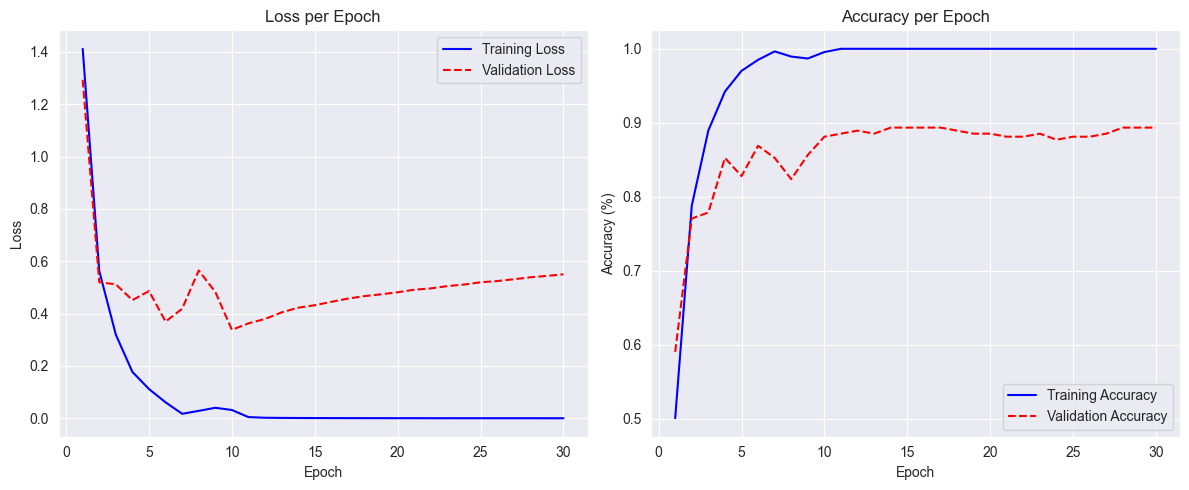

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r--', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r--', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, Y_test, lengths_test in test_loader:
        X_test, Y_test, lengths_test = X_test.to(device), Y_test.to(device), lengths_test.to(device)

        outputs_test = model(X_test, lengths_test)
        preds_test = outputs_test.argmax(dim=1)

        all_preds.extend(preds_test.cpu().numpy())
        all_labels.extend(Y_test.cpu().numpy())

In [29]:
# Accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print("Accuracy:", accuracy)

# Macro F1 (treats all classes equally)
f1_macro = f1_score(all_labels, all_preds, average='macro')
print("F1 (macro):", f1_macro)

# Micro F1 (global, same as accuracy for balanced data)
f1_micro = f1_score(all_labels, all_preds, average='micro')
print("F1 (micro):", f1_micro)

# Weighted F1 (accounts for class imbalance)
f1_weighted = f1_score(all_labels, all_preds, average='weighted')
print("F1 (weighted):", f1_weighted)

# Precision & Recall
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print("Precision (macro):", precision)
print("Recall (macro):", recall)

Accuracy: 0.8693877551020408
F1 (macro): 0.8693052382145432
F1 (micro): 0.8693877551020408
F1 (weighted): 0.8672227407412327
Precision (macro): 0.8821240963781799
Recall (macro): 0.8767454212454211


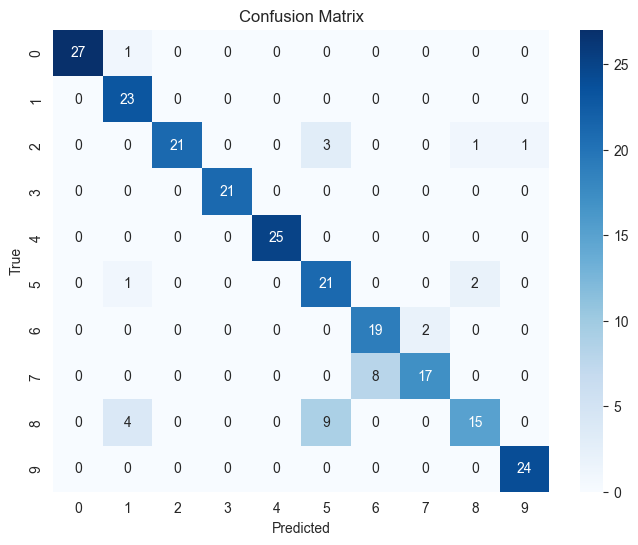

In [30]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----- Make predictions on test set -----
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_test, Y_test, lengths_test in test_loader:
        X_test, Y_test, lengths_test = X_test.to(device), Y_test.to(device), lengths_test.to(device)
        outputs = model(X_test, lengths_test)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(Y_test.cpu().numpy())

# ----- Compute confusion matrix -----
cm = confusion_matrix(all_labels, all_preds)

# ----- Plot -----
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()